In [4]:
import zipfile
from pathlib import Path
from functools import reduce
from operator import and_


import geopandas
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colassigner import ColAssigner, allcols

from src.util import get_dask_client
from src.data_dumps import month_tables, ParsedCols
from src.load_samples import covid_monday

In [7]:
class TimeCols(ColAssigner):
    def hour(self, df):
        return df[ParsedCols.dtime].dt.hour

    def day(self, df):
        return df[ParsedCols.dtime].dt.day


class PeriodCols(ColAssigner):
    def is_am(self, df):
        return (df[TimeCols.hour] >= 5) & (df[TimeCols.hour] <= 10)

    def is_noon(self, df):
        return (df[TimeCols.hour] >= 11) & (df[TimeCols.hour] <= 15)

    def is_pm(self, df):
        return (df[TimeCols.hour] >= 16) & (df[TimeCols.hour] <= 20)

    def is_dayedge(self, df):
        return (df[TimeCols.hour] < 5) | (df[TimeCols.hour] > 20)

    def anytime(self, df):
        return True

In [8]:
class ReliableDayCols(ColAssigner):
    def reliable(self, df):
        return (df[PeriodCols.is_am] > 4) & (df[PeriodCols.is_pm] > 4)

    def minimal(self, df):
        return df[PeriodCols.anytime] < 4

    def constant(self, df):
        return reduce(
            and_, [df[c] > 2 for c in allcols(PeriodCols) if c != PeriodCols.anytime]
        )

In [9]:
client = get_dask_client(72, memory_limit=0)

In [10]:
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 72
Total threads: 72,Total memory: 0 B
Comm: tcp://127.0.0.1:41805,Workers: 72
Dashboard: http://127.0.0.1:8787/status,Total threads: 72
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36805,Total threads: 1
Dashboard: http://127.0.0.1:35855/status,Memory: 0 B
Nanny: tcp://127.0.0.1:45591,


In [11]:
ddf = month_tables.get_full_ddf()

In [12]:
gb_base = (
    ddf.assign(**TimeCols())
    .assign(**PeriodCols())
    .groupby([ParsedCols.user, ParsedCols.month, TimeCols.day])[allcols(PeriodCols)]
    .sum()
    .assign(**ReliableDayCols())
)

In [13]:
user_days = gb_base.groupby(ParsedCols.user)[allcols(ReliableDayCols)].sum()

In [14]:
user_months = (
    gb_base.groupby([ParsedCols.user, ParsedCols.month])[allcols(ReliableDayCols)]
    .sum()
)

In [15]:
date_users = (
    gb_base.reset_index()
    .groupby([ParsedCols.month, TimeCols.day, ReliableDayCols.minimal])[ParsedCols.user]
    .nunique()
)

In [16]:
date_users_reliable = (
    gb_base.reset_index()
    .groupby([ParsedCols.month, TimeCols.day, ReliableDayCols.minimal])[ParsedCols.user]
    .nunique()
)

In [17]:
uddff, umdff, dudff, durdff = client.compute(
    [user_days, user_months, date_users, date_users_reliable]
)

In [18]:
uddf = uddff.result()

In [19]:
umdf = umdff.result().pipe(
    lambda df: df.assign(
        **{
            f"at_least_{i}": df[ReliableDayCols.reliable] >= i
            for i in [1, 3, 5, 9, 15, 30]
        }
    )
)

In [20]:
dudf = dudff.result()

In [21]:
durdf = durdff.result()

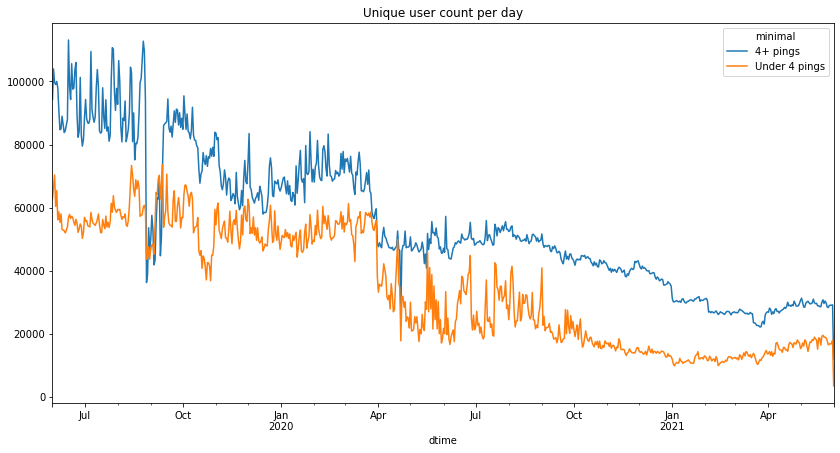

In [22]:
dudf.reset_index().assign(
    dtime=lambda df: pd.to_datetime(df["month"] + "-" + df["day"].astype(str))
).pivot_table(index="dtime", columns="minimal", values="user").rename(
    columns={True: "Under 4 pings", False: "4+ pings"}
).plot(
    figsize=(14, 7), title="Unique user count per day"
)
plt.savefig("figures/upd.png")

In [25]:
uddf.loc[:, ReliableDayCols.reliable].pipe(
    pd.cut, [0, 2, 10, 50, 1000], include_lowest=True
).value_counts().sort_index().to_frame().pipe(lambda df: print(df.to_html()))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>reliable</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>(-0.001, 2.0]</th>
      <td>4924823</td>
    </tr>
    <tr>
      <th>(2.0, 10.0]</th>
      <td>135712</td>
    </tr>
    <tr>
      <th>(10.0, 50.0]</th>
      <td>82985</td>
    </tr>
    <tr>
      <th>(50.0, 1000.0]</th>
      <td>57520</td>
    </tr>
  </tbody>
</table>


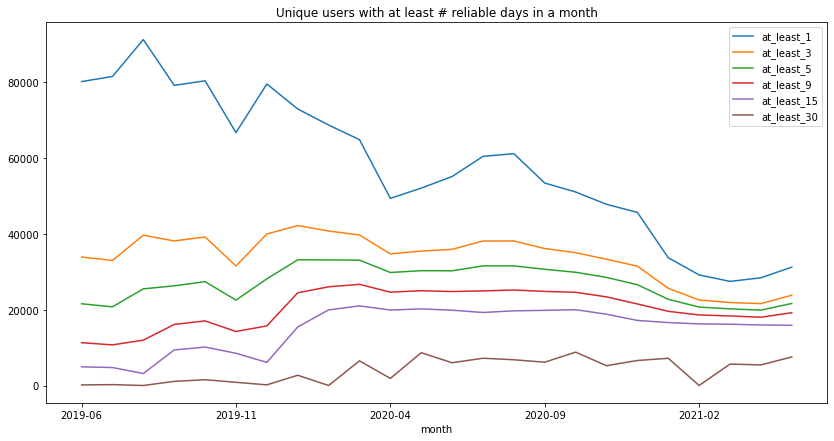

In [27]:
umdf.loc[:, lambda df: df.columns.str.startswith("at_least")].groupby(
    ParsedCols.month
).sum().sort_index().iloc[:-1, :].plot(
    figsize=(14, 7), title="Unique users with at least # reliable days in a month"
)
plt.savefig("figures/upm.png")

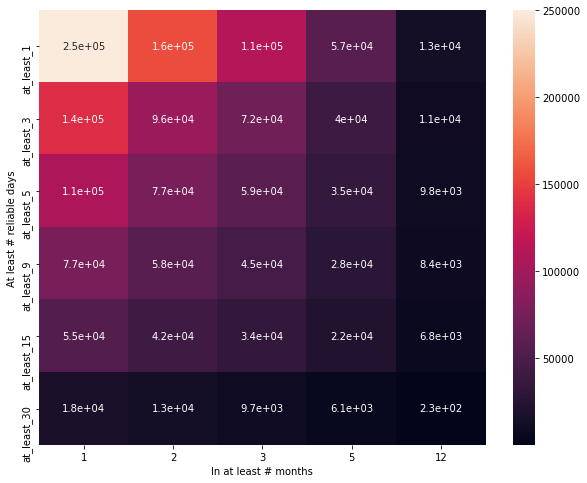

In [29]:
fig, ax = plt.subplots(figsize=(10,8))  
ax = (
    umdf.loc[:, lambda df: df.columns.str.startswith("at_least")]
    .groupby(ParsedCols.user)
    .sum()
    .pipe(lambda df: pd.DataFrame({i: (df > i).sum() for i in [1, 2, 3, 5, 12]}))
    .pipe(sns.heatmap, annot=True, ax=ax)
)

ax.set_xlabel("In at least # months")
ax.set_ylabel("At least # reliable days")
plt.savefig("figures/uhmap.png")

In [30]:
resp = requests.get("https://download.geofabrik.de/europe/hungary-latest-free.shp.zip")

In [32]:
hunpath = Path("/tmp/hun.zip")
hunpath.write_bytes(resp.content)

with zipfile.ZipFile(hunpath, "r") as zip_ref:
    zip_ref.extractall("/tmp")

In [33]:
hungdf = (
    geopandas.read_file("/tmp/gis_osm_places_a_free_1.shp")
    .loc[
        lambda df: df["fclass"].isin(["county", "city"]) & (df["name"] != "Bratislava"),
        :,
    ]
    .loc[:, ["name", "geometry"]]
    .set_index("name")
)

In [37]:
sdf = ddf.sample(frac=1e-3).compute()

In [34]:
def to_geo(df):
    return geopandas.GeoDataFrame(
        df, geometry=geopandas.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326"
    )

In [35]:
def gpjoin(df):
    return geopandas.sjoin(to_geo(sdf), hungdf, op="within", how="left").rename(
        columns={"index_right": "county"}
    )

In [38]:
geomonths = gpjoin(sdf).groupby([ParsedCols.month, "county"])[ParsedCols.user].count()

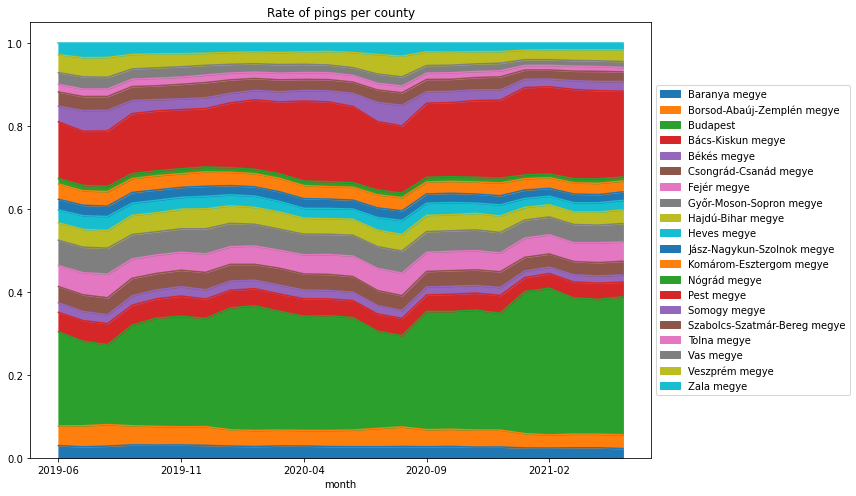

In [40]:
geomonths.reset_index().pivot_table(
    index=ParsedCols.month, columns="county", values=ParsedCols.user
).pipe(lambda df: df / df.sum(axis=1).to_frame().values).iloc[:-1, :].plot.area(
    figsize=(12, 7), title= "Rate of pings per county"
).legend(
    loc="center left", bbox_to_anchor=(1.0, 0.5)
)
plt.tight_layout()
plt.savefig("figures/county-rate.png")